# Cart and Pole Deep Q-Network Project
The original tutorial for which this project is based is located at the link below. I have made several modifications throughout.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

See also: https://www.youtube.com/watch?v=PyQNfsGUnQA&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=17

1. Initialize replay memory capacity.
2. Initialize the policy network with random weights
3. Clone the policy network, and call it the target network.
4. For each episode:
    1. Initialize the starting state.
    2. For each time step:
        1. Select an action.
            - Via exploration or exploitation.
        2. Execute selected action in an emulator.
        3. Observe reward and next state.
        4. Store experince in replay memory. 
        5. Sample random batch from replay memory.
        6. Preprocess states from batch.
        7. Pass batch of preprocessed states to policy network.
        8. Calculate loss between output Q-values and target Q-values
            - Requires a pss to the target network for the next state
        9. Gradient descent updates weights in th epolicy network to minimize loss.
            - After ***x*** time steps, weights in the target network are updated to the weights in the policy network.


## Import Libraries

In [1]:
# import sys

In [2]:
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install gym
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install torch torchvision torchaudio

In [3]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set up display

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

#imports images to notebook

## Deep Q-Network

In [5]:
class DQN(nn.Module):       #Torch nn package. Extend .mm Module class.
    #def __init__(self, img_height, img_width, action_num):
    def __init__(self, img_height, img_width): #height and witdth of image input that will be passed into the model
        super().__init__()
         
        #two fully connected hidden layers and an output layer. Fully connected layers are called Linear layers
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24) #accepts dimensions of passed in image times image width times 3.  #The 3 refers to the rgb color that will be received as input. The first linear layer will have 24 outputs
        self.fc2 = nn.Linear(in_features=24, out_features=32) #The second layer accepts 24 inputs. We specify that it has 32 outputs.
        self.fc3 = nn.Linear(in_features=32, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=2) # Our output layer will have 32 inputs from the previous layer and will have 2 outputs (left or right agent movement options).The network will output the Q values that correspond to each possible action that the agent can take from a given state. Move left or right. 

    def forward(self, t): #implements a forward pass to the network
        t = t.flatten(start_dim=1) #tensor t must be flattened before it can be passed to the fully connected layer
        t = F.relu(self.fc1(t)) #t will then be passed to the fully connected layer and then have relu applied to it.
        t = F.relu(self.fc2(t)) # that t will then be passed to this layer and then be passed ot the output layer
        t = F.relu(self.fc3(t))
        t = self.out(t) #this output layer is then what is returned by the forward function.
        return t

## Experience class

In [6]:
#Create instances of experience objects that will get stored in and sampled from replay memory later. 
# namedtuple returns a subclass 'Experience' used to create tuple object with state, action, next_state and reward (which make up an individual experience)
Experience = namedtuple( 
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [7]:
e = Experience({},[],"a","v")  #state, action, next_state, reward of e
e

Experience(state={}, action=[], next_state='a', reward='v')

## Replay Memory

In [8]:
#Store experiences. Replay Memory has some set capacity.
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] #the structure that holds the stored experiences
        self.push_count = 0 #will be used to track how many experiences added to memory
        
    def push(self, experience): #store experiences in replay memory as they occur. 
        if len(self.memory) < self.capacity: #Before adding to memory, check that there is enough capacity then append to memory. 
            self.memory.append(experience)
        else: #if memory is full, we push new experiences to the front of memory, overriding the oldest experiences first
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1 #update experience counter

    def sample(self, batch_size):  #sample experiences from replay memory. Sampled experiences are used to train DQN
        return random.sample(self.memory, batch_size) #return random number of experiences to sample
    
    def can_provide_sample(self, batch_size): #returns boolean to tell us whether we can sample from memory. The sample must be equal to the batch size used to train the network
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

In [9]:
#Exploration (random exploration of environment) vs exploitation (agent exploits what it learnt about the environemtn to take best known action from given state). The way the agent selects actions.
#Epsilon initially set to 1 to guarantee exploration of environemnt at start. Epsilon decays so agent explores less as it learns more about the environment.
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay): #start, end and decay values of epsilon.
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step): #current step of agent passed in to return the calculated exploration rate. The agent uses this exploration rate to determine how it should select its actoins by either exploring or exploiting its invironment.
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

## Reinforcement Learning Agent

In [10]:
class Agent():
    def __init__(self, strategy, num_actions, device): #Epsilon greed strategy must exist to pass in. Number of available actions are the possible actions an agent can take from a given state (2 for agent moving left or right).
        self.current_step = 0 # the agent's current step number in the environment
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):#policy net is the name given to our Deep Q Network we trained to learn the optimal policy
        rate = strategy.get_exploration_rate(self.current_step) #the rate is equal to the rate returned by the epsilon greedy strategy that was passed in when creating agent.
        self.current_step += 1 #increment agent step by 1

        if rate > random.random(): #then check to see if the exploration rate is greater than a random number between 0 and 1 corresponding to the left or right movement
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else: #if exploration rate is not greater than random number, then exploit environment by selecting the action that corresponds to the highest Q value output fromour policy network for the given state
            with torch.no_grad(): #turn off gradient tracking since we are currently using th emodel for inference and not for training.
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

## Environment Manager

In [11]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space.n
        
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
       
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.Grayscale(num_output_channels=3)
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

## Example of non-processed screen

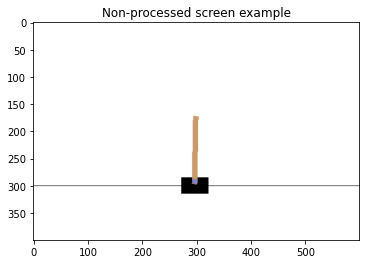

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

## Example of processed screen

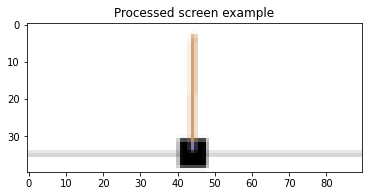

In [13]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

## Example of starting state

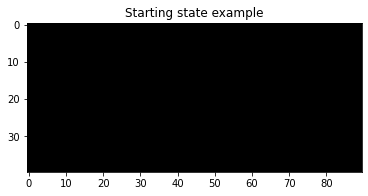

In [14]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

## Example of non-starting state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


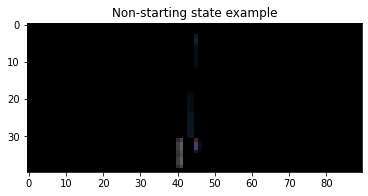

In [15]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non-starting state example')
plt.show()

## Example of end state

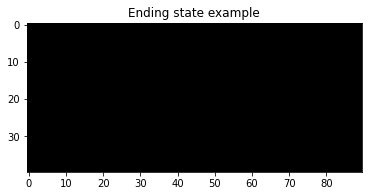

In [16]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

## Utility functions

### Plotting

In [17]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

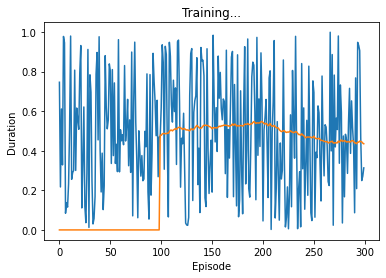

Episode 300 
 100 episode moving avg: 0.43498397


In [18]:
plot(np.random.rand(300), 100)

### Tensor processing

In [19]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

#### Example of Experience(\*zip(\*experiences)) used above
See https://stackoverflow.com/a/19343/3343043 for further explanation.

In [20]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [21]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

### Q-Value Calculator

In [22]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device.type, device)

Using device cpu cpu


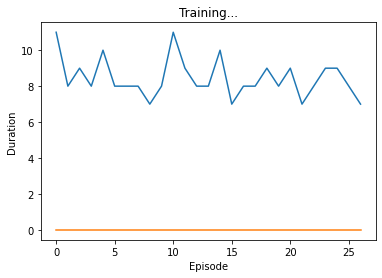

Episode 27 
 100 episode moving avg: 0.0


In [ ]:
batch_size = 256 
gamma = 0.999 
eps_start = 1 #1   #exploration rate at start
eps_end = 0.01
eps_decay = 0.99
target_update = 10 
memory_size = 1000000
lr = 0.99  #0.001  #learning rate
num_episodes = 300 # run for more episodes for better results


em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

In [ ]:
assert get_moving_average(100, episode_durations)[-1] > 15

REPEAT TESTS. EARLY ISSUES stopped testing about halfway thorugh the episodes so worth running tests for full 300 episodes. Error: Session cannot generate requests
 
If issue persists:
1. Run script with active user session. 

#### SAMPLE 1
CHANGES
   self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)  

batch_size = 256
gamma = 0.999
eps_start = 0.99 #1
eps_end = 0.05  #0.01
eps_decay = 200 #0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 300 # run for more episodes for better results

RESULTS: ***Episode 231 ***
 100 episode moving avg: 38.63

#### SAMPLE 2 - add middle layer

self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24) #accepts dimensions of passed in image times image width times 3.  #The 3 refers to the rgb color that will be received as input. The first linear layer will have 24 outputs
        self.fc2 = nn.Linear(in_features=24, out_features=32) #The second layer accepts 24 inputs. We specify that it has 32 outputs.
        self.fc3 = nn.Linear(in_features=32, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=2)

batch_size = 256
gamma = 0.999
eps_start = 0.99 #1
eps_end = 0.05  #0.01
eps_decay = 200 #0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 300 # run for more episodes for better results

RESULTS: ***Episode 135 ***
 100 episode moving avg: 37.63


#### SAMPLE 3 - change eps decay rate
batch_size = 256 
gamma = 0.999 
eps_start = 0.99 #1   #exploration rate at start
eps_end = 0.01
eps_decay = 0.001
target_update = 10 
memory_size = 1000000
lr = 0.001  #learning rate
num_episodes = 300 # run for more episodes for better results 

RESULTS: ***Episode  132 ***
 100 episode moving avg: 26.23

#### SAMPLE 4 - change eps decay rate to 0.99
batch_size = 256 
gamma = 0.999 
eps_start = 1 #1   #exploration rate at start
eps_end = 0.01
eps_decay = 0.99
target_update = 10 
memory_size = 1000000
lr = 0.001  #learning rate
num_episodes = 300 # run for more episodes for better results

RESULTS: ***Episode 183 ***
 100 episode moving avg: 39.81

#### SAMPLE 5 - change learning rate to 0.99

RESULTS: Episode  
 100 episode moving avg:


#### SAMPLE 6 - increase target update to 100